In [41]:
import glob
import numpy as np
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, random_split

# [0, 1]
# def normalize_coordinates(coords):
#     latitude, longitude = coords
#     latitude = (latitude + 90) / 180
#     longitude = (longitude + 180) / 360
#     return latitude, longitude


# def denormalize_coordinates(coords):
#     latitude, longitude = coords
#     latitude = latitude * 180 - 90
#     longitude = longitude * 360 - 180
#     return latitude, longitude

def denormalize_image(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image = np.transpose(image, (2, 0, 1))  # Change the order of dimensions to (channels, height, width)
    mean = np.array(mean)
    std = np.array(std)
    denormalized_img = image * std[:, None, None] + mean[:, None, None]
    denormalized_img = np.transpose(denormalized_img, (1, 2, 0))  # Change the order of dimensions back to (height, width, channels)
    denormalized_img = np.clip(denormalized_img, 0, 1)  # ensure values are between 0 and 1
    return denormalized_img


# [-1, 1]
def normalize_coordinates(coords):
    latitude, longitude = coords
    latitude = latitude / 90
    longitude = longitude / 180
    return latitude, longitude

def denormalize_coordinates(coords):
    latitude, longitude = coords
    latitude = latitude * 90
    longitude = longitude * 180
    return latitude, longitude


class CustomImageDatasetFromFolder(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_files = glob.glob(os.path.join(folder_path, "*.png")) 
        self.image_files += glob.glob(os.path.join(folder_path, "*.jpg"))

        self.transform = transform

    def __getitem__(self, index):
        while True:
            try:
                image_path = self.image_files[index]
                image = Image.open(image_path)

                if self.transform:
                    image = self.transform(image)

                coordinates = self._get_coordinates_from_filename(image_path)
                return {"image": image, "coordinates": coordinates}
            except OSError:
                print(f"Error loading image file: {image_path}. Skipping this file.")
                index = (index + 1) % len(self.image_files)

    def __len__(self):
        return len(self.image_files)

    def _get_coordinates_from_filename(self, filename):
        basename = os.path.basename(filename)
        coords_str = os.path.splitext(basename)[0]
        latitude, longitude = map(float, coords_str.split(","))
        return torch.tensor(
            normalize_coordinates([latitude, longitude]), dtype=torch.float32
        )


def convert_to_rgb(image):
    if image.mode != "RGB":
        return image.convert("RGB")
    return image


batch_size = 32
image_size = 256
train_ratio = 0.9

transform = transforms.Compose(
    [
        transforms.Lambda(convert_to_rgb),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

dataset_folder = "data/flickr"

dataset = CustomImageDatasetFromFolder(folder_path=dataset_folder, transform=transform)

train_length = int(train_ratio * len(dataset))
val_length = len(dataset) - train_length

# Split the dataset into train and validation sets
train_data, val_data = random_split(dataset, [train_length, val_length])
trainloader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=0
)
valloader = torch.utils.data.DataLoader(
    val_data, batch_size=batch_size, shuffle=True, num_workers=0
)

print(f"Train dataset size {len(trainloader.dataset)}, validation dataset {len(valloader.dataset)}")

Train dataset size 38525, validation dataset 4281


In [38]:
import torch
import random

# Specify the size of the random subset
subset_size = 16

# Get a random subset of indices
indices = random.sample(range(len(dataset)), subset_size)

# Create a Subset of the dataset using the random indices
subset = torch.utils.data.Subset(dataset, indices)

# Create dataloaders for the random subset
trainloader = torch.utils.data.DataLoader(
    subset, batch_size=batch_size, shuffle=True, num_workers=0
)
valloader = torch.utils.data.DataLoader(
    subset, batch_size=batch_size, shuffle=True, num_workers=0
)

print(f"Train dataset size {len(trainloader.dataset)}, validation dataset {len(valloader.dataset)}")

Train dataset size 16, validation dataset 16


In [39]:
import numpy as np
import torch
import torch.nn as nn


def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches**2, h * w * c // n_patches**2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[
                    :,
                    i * patch_size : (i + 1) * patch_size,
                    j * patch_size : (j + 1) * patch_size,
                ]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches


def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = (
                np.sin(i / (10000 ** (j / d)))
                if j % 2 == 0
                else np.cos(i / (10000 ** ((j - 1) / d)))
            )
    return result


class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.k_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.v_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head : (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head**0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])


class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.LayerNorm(mlp_ratio * hidden_d),
            nn.Linear(mlp_ratio * hidden_d, hidden_d),
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out


class MyViT(nn.Module):
    def __init__(self, chw, n_patches=4, n_blocks=2, hidden_d=32, n_heads=2):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw  # (C, H, W)
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer(
            "positional_embeddings",
            get_positional_embeddings(n_patches**2 + 1, hidden_d),
            persistent=False,
        )

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList(
            [MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)]
        )

        # 5) Classification MLP
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, 2)  # Changed output dimension to 2
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out)  # Map to output dimension, output coordinates

In [40]:
from transformers import ViTModel, ViTConfig


class GeoLocatingModel(nn.Module):
    def __init__(self, image_size=256, patch_size=16, num_classes=2, hidden_size=768, num_layers=12):
        super(GeoLocatingModel, self).__init__()

        # Configuration for the Vision Transformer
        config = ViTConfig(
            hidden_size=hidden_size,
            num_hidden_layers=num_layers,
            num_attention_heads=12,
            intermediate_size=3072,
            hidden_act="gelu",
            hidden_dropout_prob=0.1,
            attention_probs_dropout_prob=0.1,
            initializer_range=0.02,
            layer_norm_eps=1e-12,
            image_size=image_size,
            patch_size=patch_size,
            num_channels=3,
            qkv_bias=True,
            encoder_stride=16,
        )

        # The transformer model
        self.transformer = ViTModel(config)

        # A linear layer to get the final prediction
        self.prediction_head = nn.Linear(config.hidden_size, num_classes)

    def forward(self, x):
        # Pass the input through the transformer
        outputs = self.transformer(pixel_values=x)

        # Take the output corresponding to the class token and pass it through the prediction head
        x = self.prediction_head(outputs.last_hidden_state[:, 0])

        return x

In [43]:
# Function to load the model
def load_model(model, path, mode="eval"):
    model.load_state_dict(torch.load(path))
    if mode == "eval":
        model.eval()
    elif mode == "train":
        model.train()
    return model

In [60]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

num_epochs = 200
learning_rate = 0.0005
model_version = f"200e_0.0005lr_6b_256d"
l2_lambda = 1e-7  # Adjust this to control the strength of the regularization

# Instantiate the model and move to the appropriate device
# model = GeoLocatingModel()
model = MyViT(chw=(3, image_size, image_size), n_blocks=6, hidden_d=256)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

if os.path.isfile(f"./{model_version}.pth"):
    model = load_model(model, f"{model_version}.pth", mode="train")

# Set up the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)

# Train the model
for epoch in range(num_epochs):
    with tqdm(
        total=len(trainloader.dataset),
        desc="Training - Epoch: " + str(epoch) + "/" + str(num_epochs),
        unit="img",
    ) as prog_bar:
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, coordinates = data["image"].to(device), data["coordinates"].to(
                device
            )

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass, backward pass, and optimization
            outputs = model(inputs)
            loss = criterion(outputs, coordinates)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Extract the current learning rate from the optimizer
            lr = optimizer.param_groups[0]["lr"]

            prog_bar.set_postfix(**{"loss": loss.data.cpu().detach().numpy(), "lr": lr})
            prog_bar.update(batch_size)

        # Step the learning rate scheduler
        scheduler.step()

    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "lr": lr,
        },
        f"{model_version}.pth",
    )

print("Finished training")
model.eval()

val_loss = 0.0
with torch.no_grad():
    for data in valloader:
        inputs, coordinates = data["image"].to(device), data["coordinates"].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, coordinates)
        val_loss += loss.item()

print(f"Validation Loss: {val_loss / len(valloader)}")

Training - Epoch: 0/200: 38528img [12:26, 51.62img/s, loss=0.13403156, lr=0.0005]                           
Training - Epoch: 1/200: 38528img [12:10, 52.72img/s, loss=0.18018137, lr=0.000485]                           
Training - Epoch: 2/200: 38528img [12:24, 51.77img/s, loss=0.07471732, lr=0.00047]                           
Training - Epoch: 3/200:  92%|█████████▏| 35520/38525 [10:20<00:54, 55.50img/s, loss=0.12550552, lr=0.000456] 

In [45]:
model = load_model(model, "200e_0.0005lr_6b_256d.pth", mode="train")

In [ ]:
# Load model, optimizer state, epoch, and learning rate
checkpoint = torch.load(f'{model_version}.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
lr = checkpoint['lr']

In [58]:
import base64
import folium
import io
import numpy as np
import math


def test_predict(model, dataloader):
    model.eval()
    predictions = []
    actual_coords = []
    with torch.no_grad():
        for data in dataloader:
            inputs, coordinates = data["image"].to(device), data["coordinates"].to(
                device
            )
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actual_coords.extend(coordinates.cpu().numpy())
    return np.array(predictions), np.array(actual_coords)


def encode_image(item):
    image = denormalize_image(item["image"].permute(1, 2, 0).numpy())
    pil_image = Image.fromarray((image * 255).astype(np.uint8))
    buffered = io.BytesIO()
    pil_image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def haversine_distance(point_a, point_b):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(math.radians, [*point_a, *point_b])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = (
        math.sin(dlat / 2) ** 2
        + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    )
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c


def plot_images_and_locations(
    valloader, predicted_coords, actual_coords, num_samples=30
):
    # Select num_samples random items from the valloader
    random_indices = np.random.choice(
        len(valloader.dataset), num_samples, replace=False
    )

    # Create an empty map centered at the average location of the selected samples
    avg_lat = np.mean(
        [valloader.dataset[i]["coordinates"][0].item() for i in random_indices]
    )
    avg_lon = np.mean(
        [valloader.dataset[i]["coordinates"][1].item() for i in random_indices]
    )

    f = folium.Figure(width=600, height=400)
    world_map = folium.Map(
        location=denormalize_coordinates([avg_lat, avg_lon]),
        zoom_start=1,
    ).add_to(f)

    # Plot the images and their locations on the world map
    for idx in random_indices:
        item = valloader.dataset[idx]
        actual_coord = denormalize_coordinates(actual_coords[idx])
        pred_coord = denormalize_coordinates(predicted_coords[idx])

        # Add a marker with a popup image for the actual location
        actual_marker = folium.Marker(
            location=actual_coord, icon=folium.Icon(color="blue")
        )
        folium.Popup(
            f"<img src='data:image/png;base64,{encode_image(item)}'/>", max_width=300
        ).add_to(actual_marker)
        actual_marker.add_to(world_map)

        # Calculate distance between original and predicted point
        dist = haversine_distance(actual_coord, pred_coord)

        # Add a marker for the predicted location
        pred_marker = folium.Marker(location=pred_coord, icon=folium.Icon(color="red"))
        popup_html = """
            <table style="width:100%">
            <tr>
                <th>Original Coords</th>
                <td>[{actual_lat:.2f}&deg;, {actual_lon:.2f}&deg;]</td>
            </tr>
            <tr>
                <th>Predicted Coords</th>
                <td>[{pred_lat:.2f}&deg;, {pred_lon:.2f}&deg;]</td>
            </tr>
            <tr>
                <th>Distance</th>
                <td>{dist:.2f}Km</td>
            </tr>
            </table>
        """.format(
            actual_lat=float(actual_coord[0]),
            actual_lon=float(actual_coord[1]),
            pred_lat=float(pred_coord[0]),
            pred_lon=float(pred_coord[1]),
            dist=dist,
        )

        folium.Popup(popup_html, max_width=300).add_to(pred_marker)

        pred_marker.add_to(world_map)

        # Draw a line connecting the actual and predicted coordinates
        folium.PolyLine([actual_coord, pred_coord], color="gray", weight=1).add_to(
            world_map
        )

    # Display the world map
    return world_map


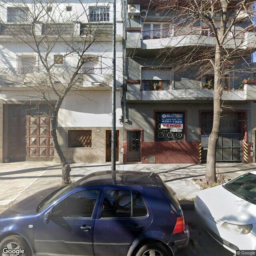
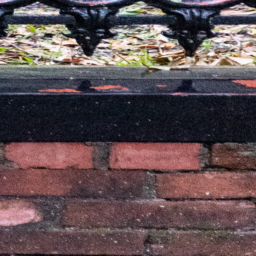
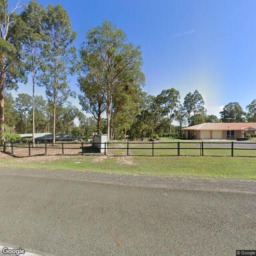
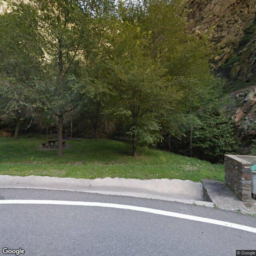
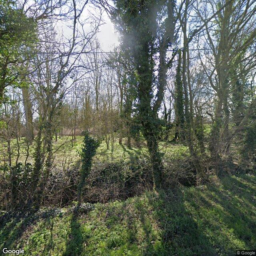
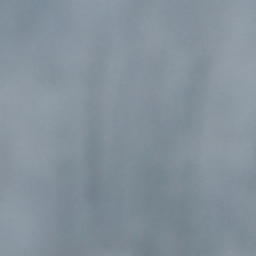
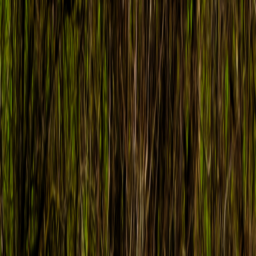
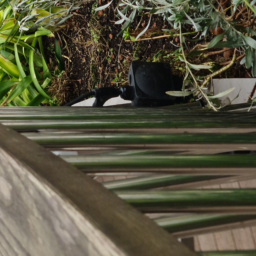
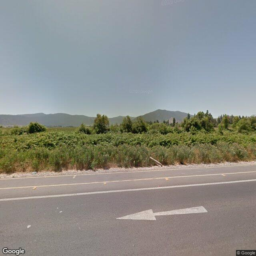
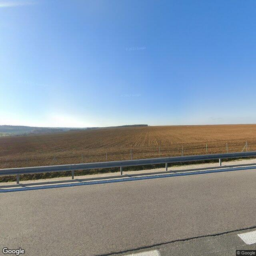
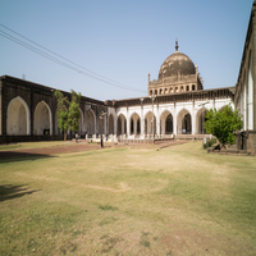
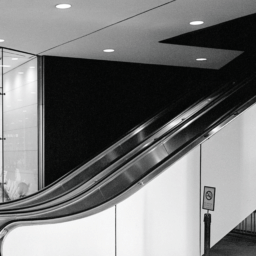
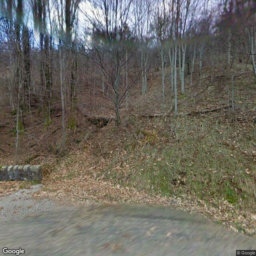
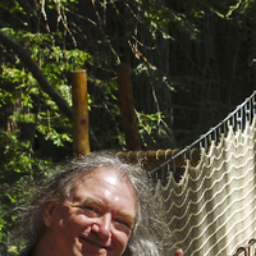
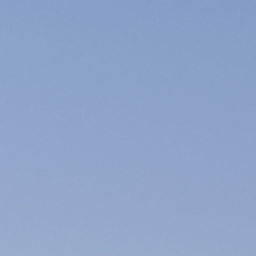
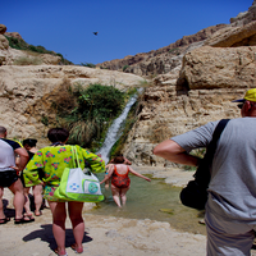

In [59]:
predicted_coords, actual_coords = test_predict(model, valloader)
plot_images_and_locations(valloader, predicted_coords, actual_coords, subset_size)